Importing Libraries and the dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from scipy.stats import entropy

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
df = pd.read_csv('/content/drive/MyDrive/finalproject/merged_data_projectb.csv')

Preprocesing and splitting the data

In [3]:
df1 = df
cols = ['FSO_Att','RFL_Att']
x = df1.drop(cols, axis=1)

In [4]:
y1 = df1['RFL_Att']
y2 = df1['FSO_Att']

Constructing the Model

<ipython-input-14-13b82a120718>:98: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_y1 = pd.concat([results_y1, pd.DataFrame([{
<ipython-input-14-13b82a120718>:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_y2 = pd.concat([results_y2, pd.DataFrame([{
<ipython-input-14-13b82a120718>:136: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the r

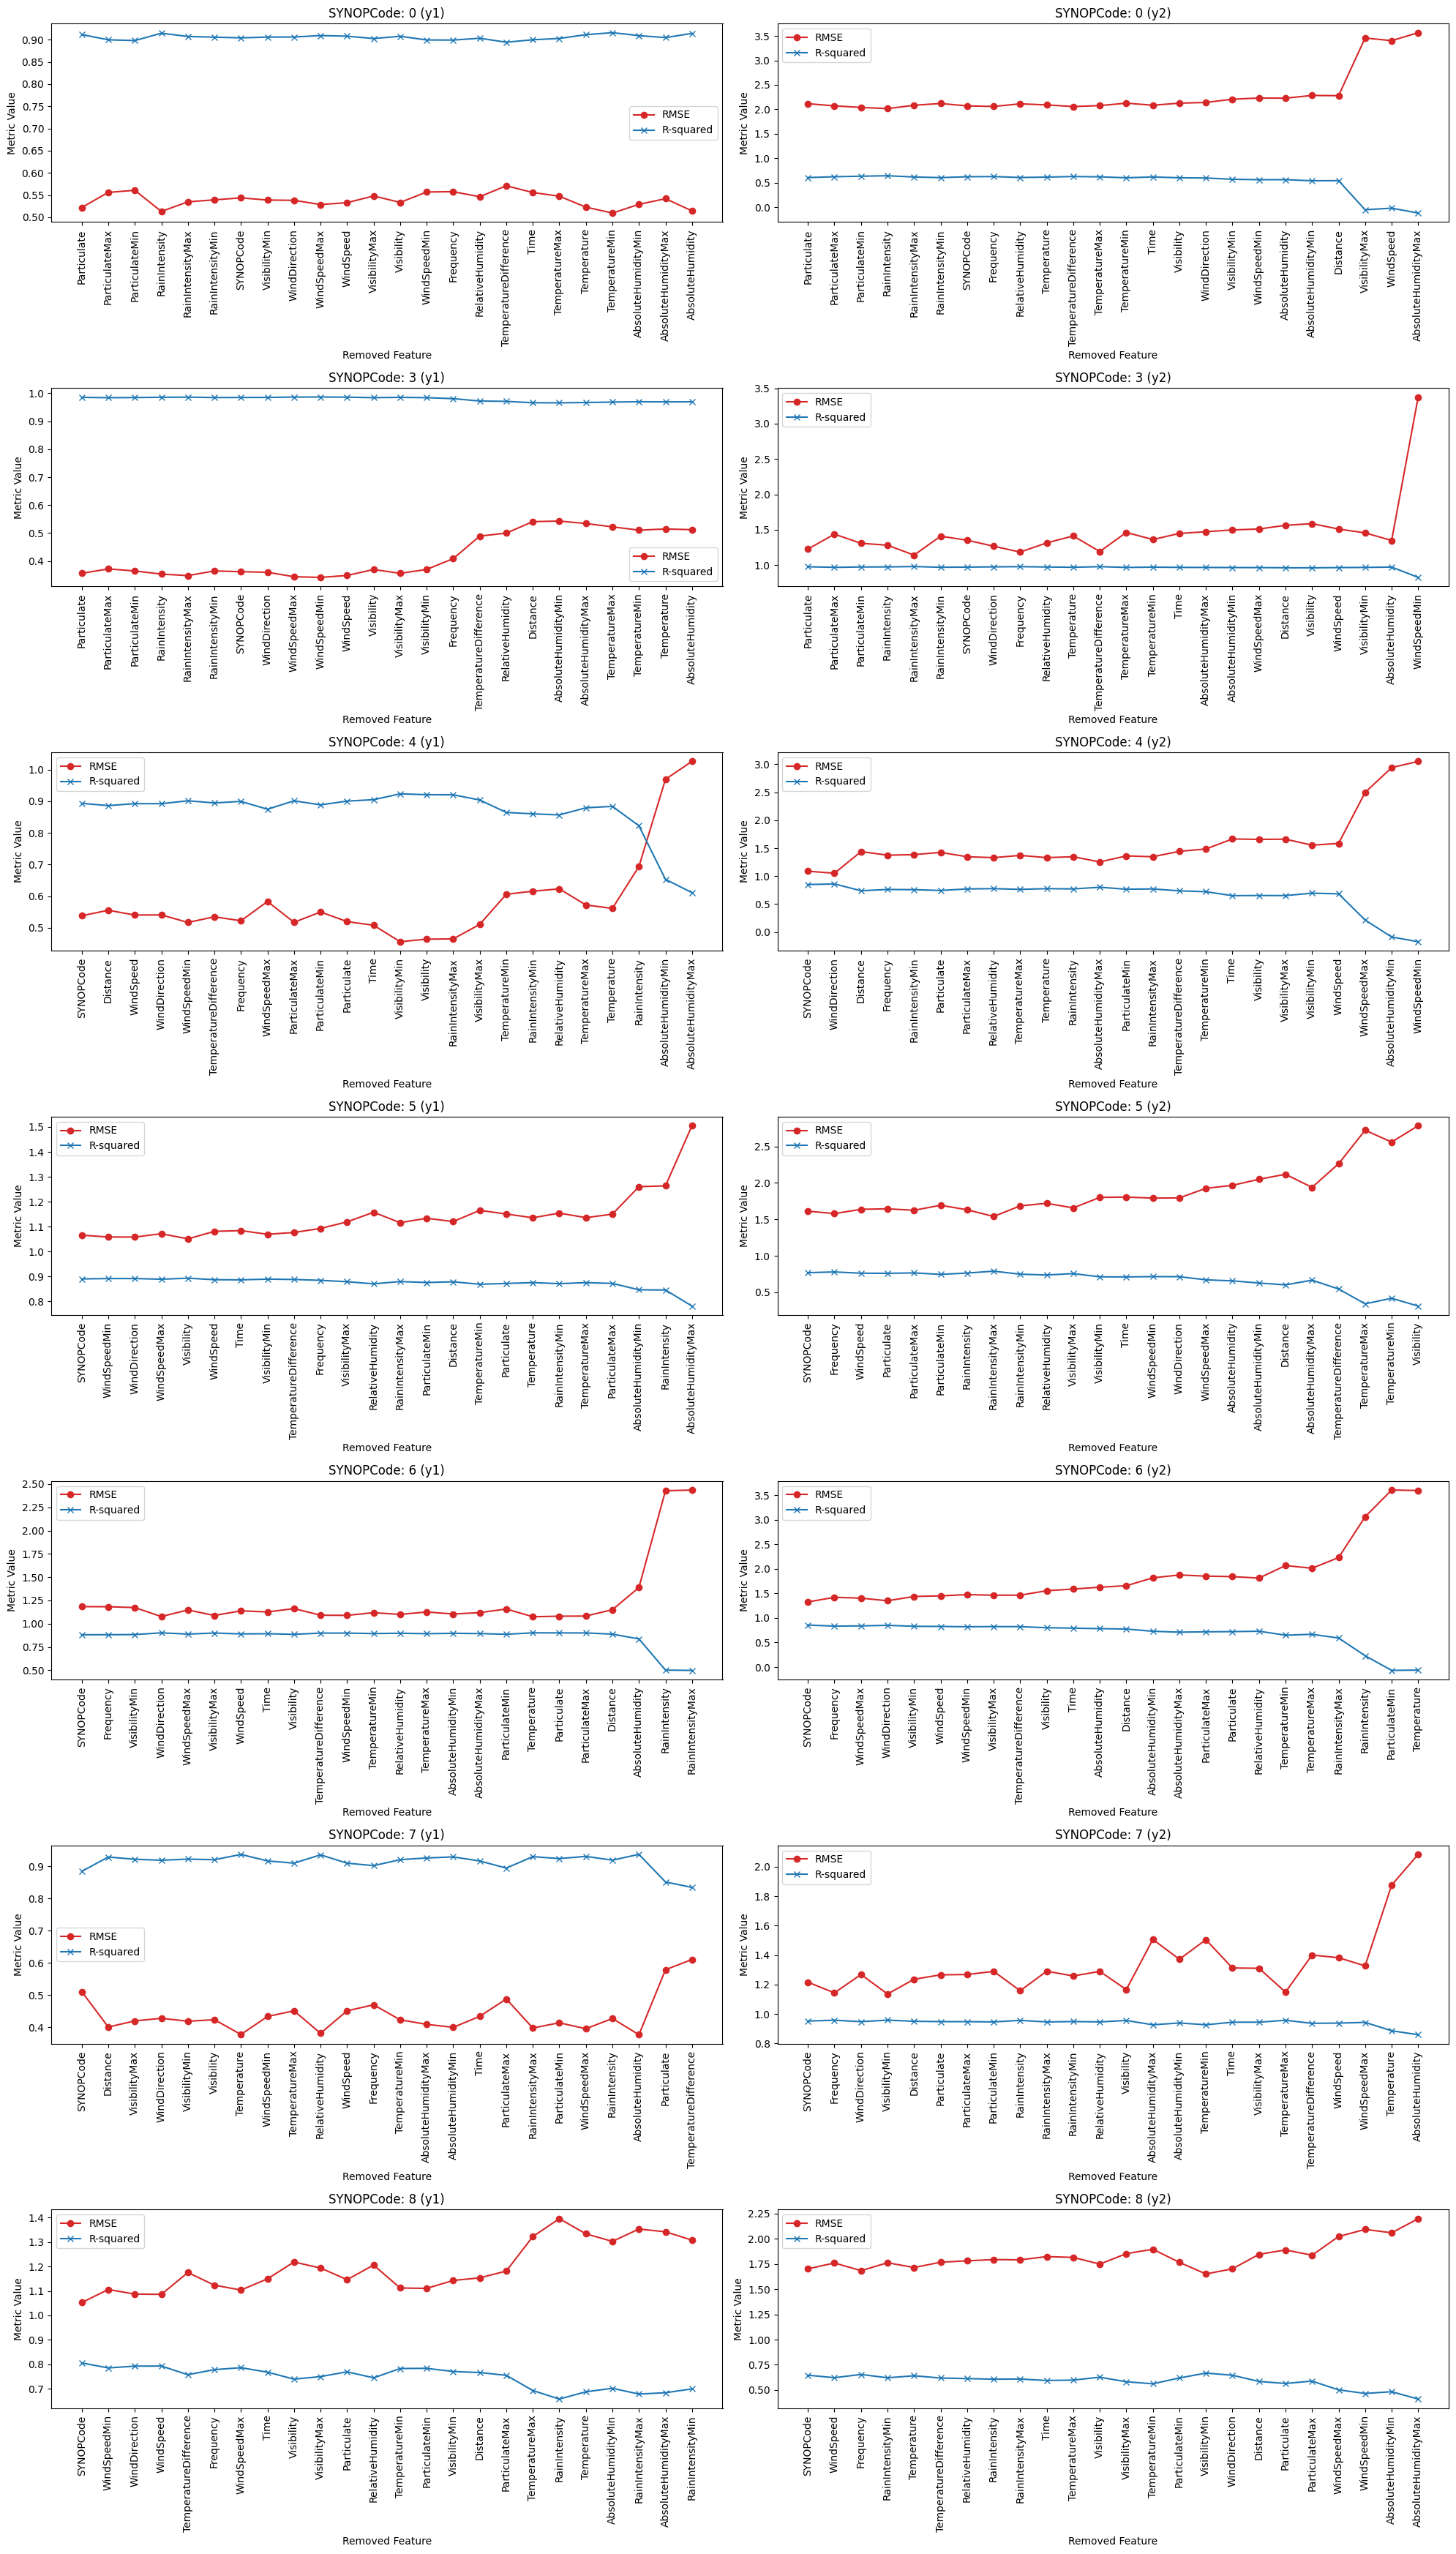

Best RMSE for y1: 0.3416976537837162
Best R-squared for y1: 0.9863788683607293
Best RMSE for y2: 1.0521086751787236
Best R-squared for y2: 0.9802026895054955


In [14]:

predictions_y1 = pd.DataFrame(columns=['SYNOPCode', 'Actual_y1', 'Predicted_y1'])
predictions_y2 = pd.DataFrame(columns=['SYNOPCode', 'Actual_y2', 'Predicted_y2'])

# Get all unique SYNOPCodes
unique_synop_codes = x['SYNOPCode'].unique()


best_rmse_y1 = float('inf')
best_r2_y1 = -float('inf')
best_rmse_y2 = float('inf')
best_r2_y2 = -float('inf')

# Create subplots for each SYNOPCode
fig, axes = plt.subplots(
    nrows=len(unique_synop_codes),
    ncols=2,
    figsize=(20, 5 * len(unique_synop_codes))
)

# Iterate over each SYNOPCode and its subplot row
for idx, synop_code in enumerate(unique_synop_codes):

    ax_y1 = axes[idx, 0]
    ax_y2 = axes[idx, 1]

    # Filter the dataset for the current SYNOPCode
    synop_data = x[x['SYNOPCode'] == synop_code]
    synop_target_y1 = y1[x['SYNOPCode'] == synop_code]
    synop_target_y2 = y2[x['SYNOPCode'] == synop_code]


    results_y1 = pd.DataFrame(columns=['Removed_Feature', 'R_squared', 'RMSE', 'Remaining_Features'])
    results_y2 = pd.DataFrame(columns=['Removed_Feature', 'R_squared', 'RMSE', 'Remaining_Features'])

    # Feature selection loop for y1 and y2
    all_features = list(range(synop_data.shape[1]))
    current_features_y1 = all_features.copy()
    current_features_y2 = all_features.copy()

    while len(current_features_y1) > 1:
        X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(
            synop_data.iloc[:, current_features_y1], synop_target_y1, synop_target_y2, test_size=0.25, random_state=42
        )

        # Train models for y1 and y2
        model_y1 = ExtraTreesRegressor(random_state=42, oob_score=True, bootstrap=True)
        model_y2 = ExtraTreesRegressor(random_state=42, oob_score=True, bootstrap=True)
        model_y1.fit(X_train, y1_train)
        model_y2.fit(X_train, y2_train)

        # Make predictions
        y1_pred = model_y1.predict(X_test)
        y2_pred = model_y2.predict(X_test)

        # Calculate metrics for y1
        mse_y1 = mean_squared_error(y1_test, y1_pred)
        rmse_y1 = np.sqrt(mse_y1)
        r2_y1 = r2_score(y1_test, y1_pred)

        # Calculate metrics for y2
        mse_y2 = mean_squared_error(y2_test, y2_pred)
        rmse_y2 = np.sqrt(mse_y2)
        r2_y2 = r2_score(y2_test, y2_pred)

        # Update best metrics for y1
        if rmse_y1 < best_rmse_y1:
            best_rmse_y1 = rmse_y1
        if r2_y1 > best_r2_y1:
            best_r2_y1 = r2_y1

        # Update best metrics for y2
        if rmse_y2 < best_rmse_y2:
            best_rmse_y2 = rmse_y2
        if r2_y2 > best_r2_y2:
            best_r2_y2 = r2_y2

        # Feature importance for y1
        importancelst_y1 = model_y1.feature_importances_
        feature_importances_y1 = {feature: importance for feature, importance in zip(current_features_y1, importancelst_y1)}
        sorted_features_y1 = sorted(feature_importances_y1, key=feature_importances_y1.get)
        least_significant_feature_y1 = sorted_features_y1[0]

        # Feature importance for y2
        importancelst_y2 = model_y2.feature_importances_
        feature_importances_y2 = {feature: importance for feature, importance in zip(current_features_y2, importancelst_y2)}
        sorted_features_y2 = sorted(feature_importances_y2, key=feature_importances_y2.get)
        least_significant_feature_y2 = sorted_features_y2[0]

        # Track results for y1
        results_y1 = pd.concat([results_y1, pd.DataFrame([{
            'Removed_Feature': synop_data.columns[least_significant_feature_y1],
            'R_squared': r2_y1,
            'RMSE': rmse_y1,
            'Remaining_Features': ', '.join(synop_data.columns[current_features_y1])
        }])])

        # Track results for y2
        results_y2 = pd.concat([results_y2, pd.DataFrame([{
            'Removed_Feature': synop_data.columns[least_significant_feature_y2],
            'R_squared': r2_y2,
            'RMSE': rmse_y2,
            'Remaining_Features': ', '.join(synop_data.columns[current_features_y2])
        }])])

        # Remove the least significant features
        current_features_y1.remove(least_significant_feature_y1)
        current_features_y2.remove(least_significant_feature_y2)


    ax_y1.plot(results_y1['Removed_Feature'], results_y1['RMSE'], color='tab:red', marker='o', label='RMSE')
    ax_y1.plot(results_y1['Removed_Feature'], results_y1['R_squared'], color='tab:blue', marker='x', label='R-squared')
    ax_y1.set_title(f'SYNOPCode: {synop_code} (y1)', fontsize=12)
    ax_y1.set_xlabel('Removed Feature', fontsize=10)
    ax_y1.set_ylabel('Metric Value', fontsize=10)
    ax_y1.tick_params(axis='x', rotation=90)
    ax_y1.legend()


    ax_y2.plot(results_y2['Removed_Feature'], results_y2['RMSE'], color='tab:red', marker='o', label='RMSE')
    ax_y2.plot(results_y2['Removed_Feature'], results_y2['R_squared'], color='tab:blue', marker='x', label='R-squared')
    ax_y2.set_title(f'SYNOPCode: {synop_code} (y2)', fontsize=12)
    ax_y2.set_xlabel('Removed Feature', fontsize=10)
    ax_y2.set_ylabel('Metric Value', fontsize=10)
    ax_y2.tick_params(axis='x', rotation=90)
    ax_y2.legend()


    predictions_y1 = pd.concat([
        predictions_y1,
        pd.DataFrame({'SYNOPCode': synop_code, 'Actual_y1': y1_test, 'Predicted_y1': y1_pred})
    ], ignore_index=True)

    predictions_y2 = pd.concat([
        predictions_y2,
        pd.DataFrame({'SYNOPCode': synop_code, 'Actual_y2': y2_test, 'Predicted_y2': y2_pred})
    ], ignore_index=True)


plt.tight_layout()
plt.show()


predictions_y1.to_csv('predictions_y1_by_synopcode.csv', index=False)
predictions_y2.to_csv('predictions_y2_by_synopcode.csv', index=False)


print(f"Best RMSE for y1: {best_rmse_y1}")
print(f"Best R-squared for y1: {best_r2_y1}")
print(f"Best RMSE for y2: {best_rmse_y2}")
print(f"Best R-squared for y2: {best_r2_y2}")


Generating Heatmaps based on probability density

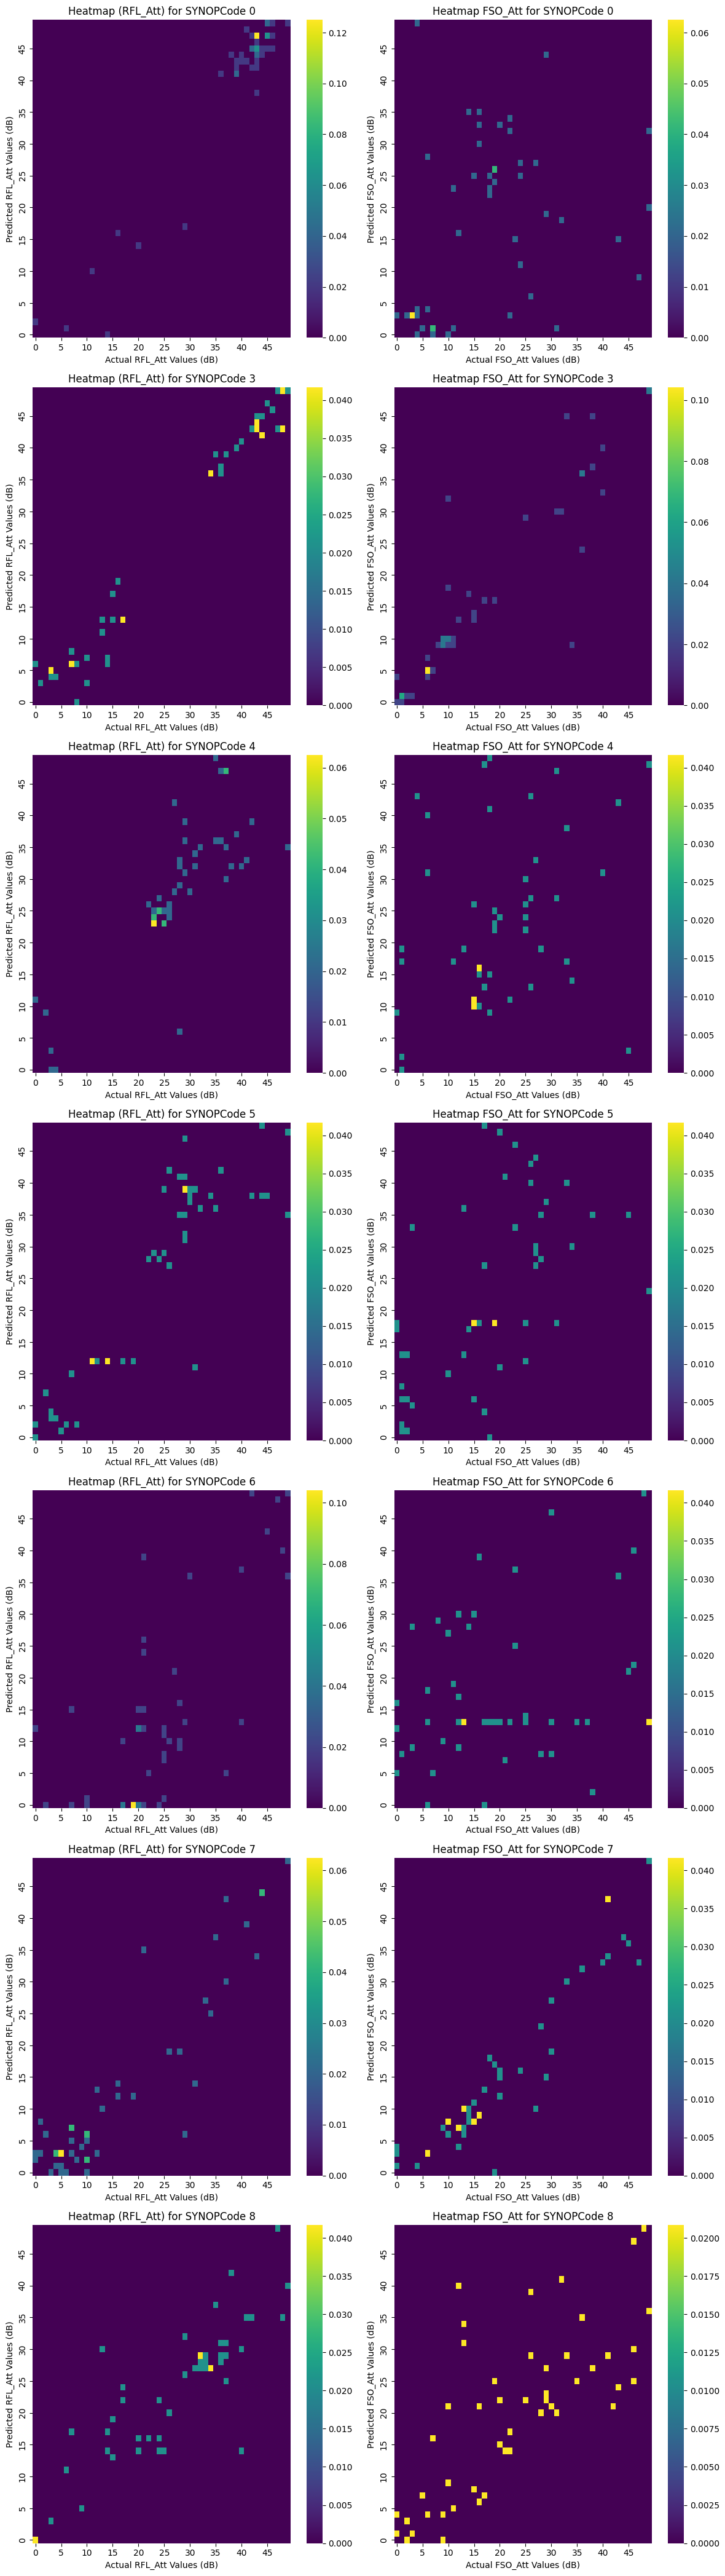


Entropy and Mutual Information Results:
   SYNOPCode    H_X_y1    H_Y_y1   H_XY_y1  Mutual_Info_y1  Normalized_MI_y1  \
0          0  3.483545  3.518855  4.897055        2.105345          0.429921   
1          3  4.504248  4.254248  5.209963        3.548533          0.681105   
2          4  4.323935  4.329987  5.319236        3.334686          0.626911   
3          5  4.659830  4.243701  5.459963        3.443568          0.630695   
4          6  4.171453  3.826163  5.218095        2.779521          0.532670   
5          7  4.504248  4.198935  5.277569        3.425614          0.649089   
6          8  4.688722  4.353846  5.459963        3.582606          0.656159   

     H_X_y2    H_Y_y2   H_XY_y2  Mutual_Info_y2  Normalized_MI_y2  
0  4.558208  4.402235  5.402569        3.557874          0.658552  
1  4.251296  4.121654  5.035702        3.337248          0.662718  
2  4.311641  4.730389  5.459963        3.582067          0.656061  
3  4.504248  4.537782  5.501629        3.54040

In [12]:

results = []

unique_synop_codes = predictions_y1['SYNOPCode'].unique()

# Create a figure for all heatmaps
num_synop_codes = len(unique_synop_codes)
fig, axes = plt.subplots(num_synop_codes, 2, figsize=(12, 6 * num_synop_codes))

for i, synop_code in enumerate(unique_synop_codes):

    df_filtered_y1 = predictions_y1[predictions_y1['SYNOPCode'] == synop_code]
    df_filtered_y2 = predictions_y2[predictions_y2['SYNOPCode'] == synop_code]


    y1_actual = df_filtered_y1['Actual_y1']
    y1_predicted = df_filtered_y1['Predicted_y1']

    # Create a 2D histogram for y1
    heatmap_data_y1, xedges_y1, yedges_y1 = np.histogram2d(
        y1_actual, y1_predicted, bins=50, range=[[y1_actual.min(), y1_actual.max()], [y1_predicted.min(), y1_predicted.max()]]
    )
    joint_prob_y1 = heatmap_data_y1 / heatmap_data_y1.sum()

    # Plot the heatmap for y1
    sns.heatmap(joint_prob_y1.T, cmap='viridis', ax=axes[i, 0], cbar=True, xticklabels=5, yticklabels=5)
    axes[i, 0].invert_yaxis()
    axes[i, 0].set_title(f'Heatmap (RFL_Att) for SYNOPCode {synop_code}')
    axes[i, 0].set_xlabel('Actual RFL_Att Values (dB)')
    axes[i, 0].set_ylabel('Predicted RFL_Att Values (dB)')

    # Calculate entropies and mutual information for y1
    marginal_x_y1 = joint_prob_y1.sum(axis=1)
    marginal_y_y1 = joint_prob_y1.sum(axis=0)
    H_X_y1 = entropy(marginal_x_y1, base=2)
    H_Y_y1 = entropy(marginal_y_y1, base=2)
    H_XY_y1 = entropy(joint_prob_y1.ravel(), base=2)
    mutual_information_y1 = H_X_y1 + H_Y_y1 - H_XY_y1


    y2_actual = df_filtered_y2['Actual_y2']
    y2_predicted = df_filtered_y2['Predicted_y2']

    # Create a 2D histogram for y2
    heatmap_data_y2, xedges_y2, yedges_y2 = np.histogram2d(
        y2_actual, y2_predicted, bins=50, range=[[y2_actual.min(), y2_actual.max()], [y2_predicted.min(), y2_predicted.max()]]
    )
    joint_prob_y2 = heatmap_data_y2 / heatmap_data_y2.sum()

    # Plot the heatmap for y2
    sns.heatmap(joint_prob_y2.T, cmap='viridis', ax=axes[i, 1], cbar=True, xticklabels=5, yticklabels=5)
    axes[i, 1].invert_yaxis()
    axes[i, 1].set_title(f'Heatmap FSO_Att for SYNOPCode {synop_code}')
    axes[i, 1].set_xlabel('Actual FSO_Att Values (dB)')
    axes[i, 1].set_ylabel('Predicted FSO_Att Values (dB)')

    # Calculate entropies and mutual information for y2
    marginal_x_y2 = joint_prob_y2.sum(axis=1)
    marginal_y_y2 = joint_prob_y2.sum(axis=0)
    H_X_y2 = entropy(marginal_x_y2, base=2)
    H_Y_y2 = entropy(marginal_y_y2, base=2)
    H_XY_y2 = entropy(joint_prob_y2.ravel(), base=2)
    mutual_information_y2 = H_X_y2 + H_Y_y2 - H_XY_y2

    # Store results in a dictionary
    results.append({
        'SYNOPCode': synop_code,
        'H_X_y1': H_X_y1,
        'H_Y_y1': H_Y_y1,
        'H_XY_y1': H_XY_y1,
        'Mutual_Info_y1': mutual_information_y1,
        'Normalized_MI_y1': mutual_information_y1 / H_XY_y1,
        'H_X_y2': H_X_y2,
        'H_Y_y2': H_Y_y2,
        'H_XY_y2': H_XY_y2,
        'Mutual_Info_y2': mutual_information_y2,
        'Normalized_MI_y2': mutual_information_y2 / H_XY_y2
    })


plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results)


results_df.to_csv('entropy_mutual_information_results.csv', index=False)

print("\nEntropy and Mutual Information Results:")
print(results_df)
